Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Data loaded
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Sequence defined
[[-2.0058984e-05  7.1462935e-05]
 [-1.5478807e-05  2.9428158e-05]
 [-8.8770736e-05  1.9175363e-04]
 ...
 [-4.2159012e-05 -1.2194294e-05]
 [-2.6598855e-05 -5.1154544e-05]
 [-1.0723040e-05 -4.6191377e-05]]
[[-2.0058984e-05  7.1462935e-05]
 [-1.5478807e-05  2.9428158e-05]
 [-8.8770736e-05  1.9175363e-04]
 ...
 [-4.2159012e-05 -1.2194294e-05]
 [-2.6598855e-05 -5.1154544e-05]
 [-1.0723040e-05 -4.6191377e-05]]
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]c:\Git\hyperbolic-tsne\hyperbolicTSNE\cost_functions_.py:327: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(145): warning #177-D: variable "k_grid_x" was declared but never referenced
          int k_grid_x = k % grid_n;
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

kernel.cu(146): warning #177-D: variable "k_grid_y" was declared but never referenced
          int k_grid_y = int(k / grid_n);
              ^

kernel.cu(95): warning #177-D: variable "grid_x" was declared but never referenced
      int grid_x = i_grid_index % grid_n;
          ^

kernel.cu(96): warning #177-D: variable "grid_y" was declared but never referenced
      int grid_y = int(i_grid_index / grid_n);
          ^

kernel.cu(102): warning #177-D: variable "max_square_dist" was declared but never referenced
      double max_square_dist = 0.0;
             ^

kernel.cu(103): warning #

Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.86436 grad_norm: 2.36746e+00:  25%|██▌       | 189/750 [01:16<03:48,  2.46it/s]
C:\Users\Milan\AppData\Local\Temp\ipykernel_5836\1863667756.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


4
Execution time: 207.96701431274414 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Sequence defined
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 101.74728 grad_norm: 5.95677e-01: 100%|██████████| 250/250 [03:52<00:00,  1.07it/s]


Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.69040 grad_norm: 5.03539e+02:  33%|███▎      | 249/750 [04:12<08:27,  1.01s/it]
C:\Users\Milan\AppData\Local\Temp\ipykernel_5836\1863667756.py:225: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


4
Execution time: 485.3150918483734 seconds


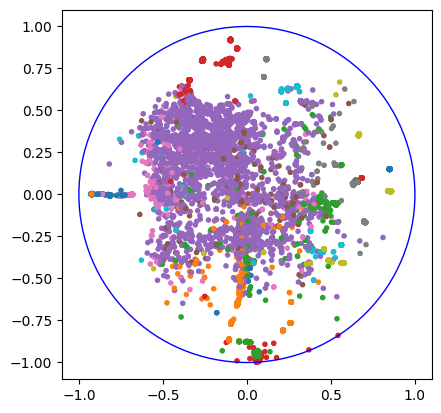

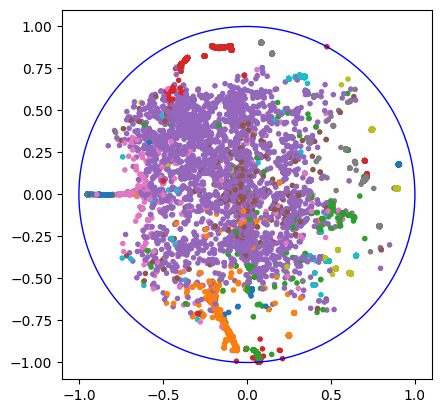

In [1]:
import os
import traceback
import numpy as np
import time
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE

data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.PLANARIA  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 10000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 30  # we use a perplexity of 30 in this example

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

print("Data loaded")

exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.












# ============= RUNNING EXACT GPU =============







opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=False,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

start_time = time.time()

try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-inexact.png")









# ============= RUNNING EXACT CPU =============






opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=True,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

log_path = "temp/poincarecpu/"  # path for saving embedding snapshots

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

start_time = time.time()

try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    #print("would run exact")
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-exact.png")